# Hyper-parameter Tuning

# Definition

Hyper-parameters control the fitting behavior and are not learned from data.

```
estimator.get_params()
```

If you think of your estimator as a black-box, hyper-parameters are knobs on the outside of the box.
The goal of *hyper-parameter tuning* is to set the nobs to get optimal performance.

<img src="img/hp-tuning-two-knobs.jpg">
<div style="text-align: right">Source: Wikipedia</div>

# Why hyper-parameters?

HPs control the fitting behavior thus they "guide" the model search. You can think of this guidance as injecting *bias* into the model. 

<img src="img/eslii-mdl-search.png" style="width:400px;">
<div style="text-align: right">Source: T. Hastie et al. (2017) "Elements of Statistical Learning (Ed. 2)"</div>

# Examples

`sklearn.svm.SVC`
  * C ... complexity, higher C means more variance can be captured.
  * gamma ... width of the RBF kernel, higher means more smoothness bias.
  
`sklearn.ensemble.RandomForestClassifier`
  * max_depth ... the deeper the trees the more variance we can capture.
  * n_features ... the more de-correlated trees, the more variance reduction (but the more trees needed).
  
`sklearn.linear_model.Ridge`
  * alpha ... penalty on the L2 norm of the model coefficients, higher alpha more bias.

# Hyper-parameter Tuning

*Grid Search* 

    Defacto standard method for tuning hyper-parameters in the past decades.
    
    
*Random Search*

    Explore the hyper-parameter space randomly by drawing samples. 
    Good for high-dimensional spaces (e.g. DNN).
    
    
<img src="img/bergstra12-grid-vs-rand.png" style="width:600px;">
<div style="text-align: right">Source: J. Bergstra and Y. Bengio (2012) "Random Search for Hyper-Parameter Optimization"</div>

# When is Grid Search not a good fit?
<img src="img/hp-tuning-many-knobs.jpg" >
<div style="text-align: right">Source: Wikipedia</div>

# Hyper-parameter Tuning in Scikit-learn

A search consists of:

  * an estimator (regressor or classifier such as `sklearn.svm.SVC()`);
  * a parameter space (e.g. `{'gamma': [0.01, 0.1, 1.0]}`);
  * a method for searching or sampling candidates;
  * a cross-validation scheme; and
  * a score function (e.g. `sklearn.metrics.accuracy_score`).
  
## Classes

  * `GridSearchCV`
  * `RandomizedSearchCV`

In [1]:
from sklearn.datasets import load_boston
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

data = load_boston()
print("Description\n{}\n{}".format('-' * 10, data.DESCR))
X = data.data
y = data.target
X = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

est = SVR()

est.fit(X_train, y_train)

print("model score: %.3f" % mean_absolute_error(y_test, est.predict(X_test)))

Description
----------
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,00

In [3]:
est = SVR()

param_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01], 'kernel': ['rbf']},
 ]

gs = GridSearchCV(est, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1)
gs.fit(X_train, y_train)

print("best params: {}".format(gs.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, gs.predict(X_test)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best params: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
model score: 3.047


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.4s finished


In [4]:
import scipy

est = SVR()

param_grid = {
    'C': scipy.stats.expon(scale=100), 
    'gamma': scipy.stats.expon(scale=.1), 
    'kernel': ['rbf', 'linear']
}

gs = RandomizedSearchCV(est, param_grid, cv=3, scoring='neg_mean_absolute_error', 
                        n_iter=12, verbose=1, random_state=0)
gs.fit(X_train, y_train)

print("best params: {}".format(gs.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, gs.predict(X_test)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best params: {'C': 49.88720138545616, 'gamma': 0.18083692319941533, 'kernel': 'rbf'}
model score: 2.946


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.8s finished


Populating the interactive namespace from numpy and matplotlib


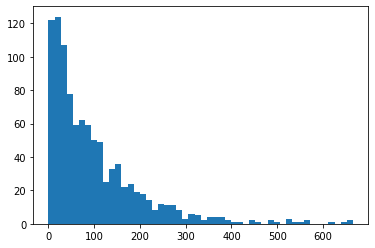

In [5]:
%pylab inline

import scipy
dist = scipy.stats.expon(scale=100)
_ = plt.hist(dist.rvs(1000), 50)

# Tuning Shortcuts

### Fit-once-evaluate-many

Some models allow us to evaluate many hyper-parameter settings in a single fit. 
Examples: n_estimators in `RandomForest` and `GradientBoosting`; "regularization path" in linear models.
    
### Warm-starts

Some models converge faster when warm started from a previous solution (with different HP settings). See [warm_start](https://scikit-learn.org/stable/glossary.html#term-warm-start) in sklearn.
    
### Heuristics

For some hyper-parameters, good values or ranges can be compute via heuristics.
Example: `gamma='auto'` in RBF kernel. 
    
### Sub-sampling

For some hyper-parameters, we can probe for good values on a subset of the data. Be cautious though!
Example: `learning_rate` in SGD.